In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

Create New Simulator Example
==========================
In this example, we will create a new simulator using the simulator core class.  We will build a simulator for an inverted pendulum system similar to the built in pendulum simulator.  The result of this example will be a simulator like that from openAI Gym.

## Young Knight Simulator Overview
YoungKnight simulators are based around 5 main components:
1. State.  The State is a vector of values such as position, velocity, voltage, current, etc. that are time dependant values that make up the dynamics of the system
2. Parameters.  Parameters are non-time dependant values, traditional parameters include mass, damping coefficients, spring constants, mass, etc (note in some more complex systems, these values are not necissarially constant, and should thus be considered part of the state, but that is beyond the scope of this tutorial)
3. Observations: Observations are functions of the State, and represent what is output by a system.  This can be the full state in a full state feedback configuration, or it can be some linear or nonlinear combination of the states.
4. Inputs: The inputs to a system are the values we have control over.  For example, we may be able to apply a force to a mass, or voltage to a motor.
5. Reward: This is a more arbitrary measurment related more to the learning aspects than to the system itself.  Generally, it should have a global maximum at a desired state.
YoungKnight Simulators should be designed to compute simulations in batches, I.E. they should be able to run multiple simulations at once.  This makes running them much more functional.

## Pendulum Problem
The inverted pendulum problem can be described with the following differential equation:
\begin{equation}
J\ddot{\theta} + c\dot{\theta} - mgr\sin\left(\theta\right) = \tau
\label{eq:dyn}
\end{equation}
where $J$ is the moment of inertia of the pendulum, $c$ is a damping coefficient $m$ is the mass of the pendulum, $g$ is the gravitational constant, and $r$ is the distance to the center of gravity of the pendulum.  If the pendulum is a narrow rod of length $l$, then we can say that $J=\frac{ml^2}{3}$ and $r=\frac{l}{2}$.  The degree of freedom in the system is $\theta$ which is the angle that the pendulum sits at.  Given the dynamics specified in \eqref{eq:dyn}, note that the equilibrium at the origin is where the pendulum is in its inverted configureation.

Since this is a second order system with a single degree of freedom, the state is $x=\left[\theta\ \omega\right]^T$m the input is $u = \left[\tau\right]$ and the parameters are $m$, $l$, $c$, and $g$.  We can then reframe the dynamical system in a state space form:
\begin{equation}
\dot{x} = 
\begin{bmatrix}
\dot{\theta} \\
\dot{\omega}
\end{bmatrix} =
\begin{bmatrix}
\omega \\
\frac{3\tau}{ml^2} + \frac{3g}{2l}\sin\left(\theta\right) - \frac{3c}{ml^2}\omega 
\end{bmatrix} = g\left(x, u; p\right)
\end{equation}

We now have the continuous dynamics in a state space form $\dot{x}=g\left(x\right)$.  Many Machine Learning techniques require a discrete system however.  To make this system into a descrete system, we will use a quantization factor $\Delta t$ with numerical integration.  The simpelest form of numerical integration is euler integration where $x_{t+1}=x_t+\Delta t g\left(x_t\right)$, however this method does not conserve energy well and often ends up adding energy to the system resulting in inacurate and runaway simulations.  To counter this, we will use a simple modification of traditional euler integration called semi-implicit euler integration that can be applied to second order differential equations such as that in \eqref{eq:dyn}.  This method is implimented as follows:
\begin{align}
\alpha_{t+1} &= \frac{3\tau_t}{ml^2} + \frac{3g}{2l}\sin\left(\theta_t\right) - \frac{3c}{ml^2}\omega_t \label{eq:alpha} \\
\omega_{t+1} &= \omega_t + \Delta t \alpha_{t+1} \label{eq:omega} \\
\theta_{t+1} &= \omega_t + \Delta t \omega_{t+1} \label{eq:theta}
\end{align}
Using this integration will result in more accurate simulation results overall.

The reward is less part of the system dynamics and more related to what we want to learn.  For the purposes of this example, let us say we are trying to learn a control policy to stabalize the unstable equilibrium at the origin.  To do this we perscribe a quadratic cost on the state, as well as quadradic cost on the action.  The cost on the state incentivizes the state moving towards the origin, while the cost on the action decentivizes large actions.  Another note with this particular system is that its state space is a cylinder, thus the equlibrium we wish to achieve actually exists in muliple points when the cylinder is unwrapped onto a cartesian plane.  To account for this we unwrap the position before calculating the cost.
\begin{equation}
\hat{\theta} = \left(\left(\theta + \pi\right) \pmod{2\pi}\right) - \pi
\end{equation}
We then define a quadratic cost
\begin{equation}
c = \hat{\theta}^2 + \gamma_1\omega^2 + \gamma_2\tau^2
\end{equation}
In this cost, we have weights $\gamma_1$ and $\gamma_2$ that can be tuned to get different performance.  Since our simulator outputs reward, not cost, we simply negate the cost to get a reward.

## Building Simulator
To realize this system in a YoungKnight Simulator, we make a new class that inherits from the simulator core class:

In [2]:
import numpy as np
from youngknight.core import Simulator

class myPendulum(Simulator):
    def __init__(self, limits, dt, name='myPendulum'):
        self.limits = limits
        self.dt = dt
        super(myPendulum, self).__init__(state_size=(2,), action_size=(1,), obs_size=(3,), name=name)
        
    def step_forward(self, state, action, k, params):
        theta = state[:, 0]
        omega = state[:, 1]
        tau = action[:, 0]
        m = params[:, 0]
        l = params[:, 1]
        c = params[:, 2]
        g = params[:, 3]
        
        # clip tau to enforce specified lilmits
        tau = np.clip(tau, self.limits['tau_min'], self.limits['tau_max'])
        
        # calculate updates based on system dynamics equations (3), (4), and (5)
        alpha = 3*tau/(m*l**2) + 3*g/(2*l)*np.sin(theta) - 3*omega*c/(m*l**2)
        new_omega = omega + self.dt*alpha
        new_theta = theta + self.dt*new_omega
        
        # clip angular velocity
        new_omega = np.clip(new_omega, self.limits['omega_min'], self.limits['omega_max'])
        
        return np.concatenate((np.expand_dims(new_theta, axis=-1), np.expand_dims(new_omega, axis=-1)), axis=1)
    
    def action_gen(self, state, observ, k, params):
        n = state.shape[0]
        a_min = np.array([self.limits['tau_min']])
        a_max = np.array([self.limits['tau_max']])
        return np.tile(a_min, (n, 1)) + np.tile(a_max - a_min, (n, 1))*np.random.rand(n, 1)
        
    def obs_gen(self, state, k, params):
        theta = state[:, 0:1]
        omega = state[:, 1:]
        return np.concatenate((np.cos(theta), np.sin(theta), omega), axis=1)
        
    def reward_gen(self, state, state1, action, k, params):
        theta = ((state[:, 0] + np.pi)%(2*np.pi)) - np.pi
        omega = state[:, 1]
        tau = action[:, 0]
        cost = theta**2 + 0.1*omega**2 + 0.001*tau**2
        return -cost
        
    def done_gen(self, state, k, params):
        n = state.shape[0]
        return np.zeros(n, dtype='bool')
        
    def noise_gen(self, state, k, params):
        return [np.zeros(state.shape), np.zeros(state.shape)]
        
    def param_gen(self, n):
        p_min = np.array([[self.limits['m_min'], self.limits['l_min'], self.limits['c_min'], self.limits['g_min']]])
        p_max = np.array([[self.limits['m_max'], self.limits['l_max'], self.limits['c_max'], self.limits['g_max']]])
        return np.tile(p_min, (n, 1)) + np.tile(p_max-p_min, (n, 1))*np.random.rand(n, 1)
        
    def init_state_gen(self, n):
        x_min = np.array([[self.limits['theta_min'], self.limits['omega_min']]])
        x_max = np.array([[self.limits['theta_max'], self.limits['omega_max']]])
        return np.tile(x_min, (n, 1)) + np.tile(x_max-x_min, (n, 1))*np.random.rand(n, 1)

The first thing to do when making a simulator is to overload the initializer.  This allows the simulator to be passed parameters specific to the system being simulated.  In this example, we pass a dictionary of limits for the parameters as well as the state and actions, as well as the time step $\Delta t$.  We then call the parent class' initializer, passing it the size of the state space, observation space, and the action space.  Next we define several functions that are required for the simulator to work:

* ``step_forward`` is where the meat of the simulation is.  This function takes in the current state and an action, as well as the current time step and a set of parameters, and calulates the new state.  This function impliments the system dynamics from (3), (4), and (5).
* ``action_gen`` takes the current state and observation, as well as the current time step and parameters and calculates an action.  This can be a control policy, or in this case, just generate a random action.
* ``obs_gen`` takes the current state as well as timestep and parameters anc calculates the observation for that step.
* ``reward_gen`` tales the current state, next state, and action, as well as the timestep, and parameters and calculates the reward based on (7)
* ``done_gen`` takes the current state, as well as timestep and params and says whether or not the simulation has reached a terminal state.  since this particular system has no terminal condition, we simply return false.
* ``noise_gen`` The youngknight simulator supports adding both measurement and process noise to your system, however, for this example, we will not be adding any noise.
* ``param_gen`` takes an integer number and generates that many parameter vectors based on the limits provided
* ``init_state_gen`` takes an integer number and generates that many inital states.

Note that each of these functions work in batches where the batch size is the first dimension of each array.

Now that we have made our pendulum class, we can use it generate trajectories and simulate our system.  We will first set up the limits dictionary, then pass that to the class constructor


In [3]:
limits = {}
limits['tau_min'] = 0.0
limits['tau_max'] = 0.0
limits['m_min'] = 0.5
limits['m_max'] = 5.0
limits['l_min'] = 0.5
limits['l_max'] = 2.0
limits['c_min'] = 1.0
limits['c_max'] = 2.0
limits['g_min'] = 9.81
limits['g_max'] = 9.81
limits['theta_min'] = -np.pi
limits['theta_max'] = np.pi
limits['omega_min'] = -10.0
limits['omega_max'] = 10.0

dt = 0.01

sim = myPendulum(limits, dt, 'create_sim_example')

We can now generate trajectories and plot the results with matplotlib.

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6203.41it/s]


Text(0,0.5,'velocity (rad/s)')

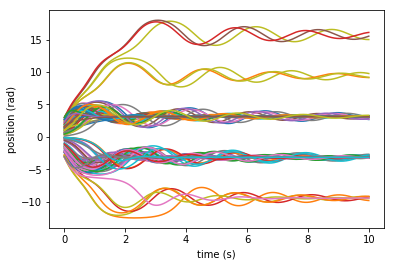

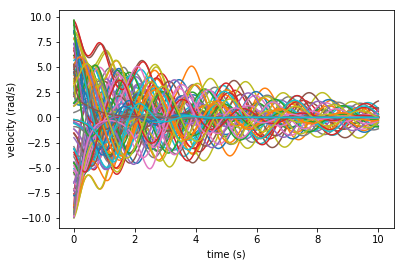

In [5]:
horizon = 1000
n_sims = 100

x_0 = sim.init_state_gen(n_sims)
p = sim.param_gen(n_sims)

res, _ = sim.gen_trajectories(x_0, horizon, params=p, verbosity=1)

t = np.arange(horizon+1)*dt

import matplotlib.pyplot as plt
plt.figure()
plt.plot(t, res['states'][:, :, 0].T)
plt.xlabel('time (s)')
plt.ylabel('position (rad)')

plt.figure()
plt.plot(t, res['states'][:, :, 1].T)
plt.xlabel('time (s)')
plt.ylabel('velocity (rad/s)')


This code runs 100 pendulum simulations for 10 seconds.  This can be modified by adjusting the horizon and n_sim variables.  Another note is that we set the limits of the inputs at zero meaning that the responses shown here are all zero input responses.  There are a number of other things that can be done from here, for example:

* Adjust the input limits to allow random inputs to be applied
* Modify the gen